In [1]:
import os
import glob
import pandas as pd 
import geopandas as gpd
from geopandas import GeoDataFrame
import os
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pylab as plt
import math
import seaborn as sns

from urllib.error import HTTPError
import urllib.request as request
try:
    from urllib import urlretrieve as urlretrieve
except ImportError:
    from urllib.request import urlretrieve as urlretrieve
    
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.statespace as smstate

from statsmodels.graphics.api import qqplot
import pylab as pl
 
pd.options.mode.chained_assignment = None
%matplotlib inline

##  Need the shapefile that manrique got, didnt find shpfile in drive. so i am redoing here 

In [2]:
masterdata = os.getenv("Master")
if masterdata is None:
    os.environ["Master"] = "{}/ML4C/Project".format(os.getenv("HOME"))
    masterdata = os.getenv("Master")
    print("Warning: Master environmental variable not found and set by code, please review!")
print("Master: {}".format(masterdata))

Master: /Users/amber/ML4C/Project


In [3]:
def getGeoDataFrameFromShpFileZipUrl(url):
    '''
    This function downloads the zip file, unzips it into the dorectory 
    pointed to by PUIdata environment variable. Then it 
    reads it into a gepandas dataframe
    '''
    
    folderName = 'shape'+ \
        str(len(os.listdir(os.getenv('Master')))+1)
    os.makedirs(os.getenv('Master') + '/' + folderName)
    urlretrieve(url, "region.zip")
    os.system('unzip -d $Master'+'/'+folderName+' region.zip')
    filenames = [f for f in os.listdir(os.getenv('Master') + '/' + folderName) if f.endswith('.shp') ]
    shapeFile = filenames[0]
    shapeFilePath = os.getenv('Master') + '/' + folderName + '/' + shapeFile
    return gpd.GeoDataFrame.from_file(shapeFilePath)

In [4]:
NYCzip=gpd.read_file('Data/14000.shp')

In [5]:
NYCzip.rename(columns={"GEO_ID": "GEOID"},inplace=True)
NYCzip.GEOID = NYCzip.GEOID.astype(str).str[-11:]
NYCzip.GEOID = NYCzip.GEOID.astype(int)

In [6]:
cols = ['GEOID']
NYCzip = NYCzip.loc[:,cols]
#NYCzipgdp.plot(column='GEOID',legend = True)
NYCzip.shape

(2166, 1)

In [7]:
NYzip_url = 'https://planninglabs.carto.com/api/v2/sql?filename=region&q=SELECT%20%2A%20FROM%20region_censustract_v0&format=SHP'
NYzip = getGeoDataFrameFromShpFileZipUrl(NYzip_url)

In [8]:
NYzip.rename(columns={"geoid": "GEOID"},inplace=True)
NYzip.GEOID = NYzip.GEOID.astype(int)
cols = ['GEOID','geometry']
NYCzipgdp = NYzip.loc[:,cols]


In [9]:
NYCzipgdp = NYCzipgdp.merge(NYCzip,on='GEOID')
NYCzipgdp.head()

,GEOID,geometry
0,36081113900,POLYGON ((-73.79190199967752 40.76893599959674...
1,36061025700,POLYGON ((-73.95068000038171 40.81084300040413...
2,36047000502,POLYGON ((-73.99136499969497 40.69701000031133...
3,36081015802,POLYGON ((-73.81497399975029 40.68669500037402...
4,36047116000,POLYGON ((-73.88618300014529 40.66752100019399...


In [10]:
Censuspd = pd.read_stata('Data/UDP_NYC_Variables.dta')
Censuspdgdp = gpd.GeoDataFrame(Censuspd)

In [11]:
for column in Censuspdgdp.columns:
    Censuspdgdp[column] = pd.to_numeric(Censuspdgdp[column].values, errors='coerce')

In [12]:
Censuspdgdp.rename(columns={'GEOid2': "GEOID"},inplace=True)
Censuspdgdp.tail(2)

,GEOID,hh16,moe_hh16,per_col00,per_nonwhite00,per_rent00,vli2000,li2000,mi2000,hmi2000,...,pop90,per_col90,moe_hu16,hinc16,moe_hinc16,popgrowth,hinc00,hinc90,pct_ch_hinc90_00,pct_ch_hinc00_16
5336,36119984000,92.0,37.0,0.121495,0.517544,0.0,0.220431,0.394953,-1.490116e-08,0.019975,...,749.0,0.255689,48.0,38929.0,16474.0,-54.0,46444.95,55472.790653,-0.162744,-0.161825
5337,36119985000,0.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
data_census = NYCzipgdp.merge(Censuspdgdp,on='GEOID')
data_census.tail()

,GEOID,geometry,hh16,moe_hh16,per_col00,per_nonwhite00,per_rent00,vli2000,li2000,mi2000,...,pop90,per_col90,moe_hu16,hinc16,moe_hinc16,popgrowth,hinc00,hinc90,pct_ch_hinc90_00,pct_ch_hinc00_16
2159,36061021703,POLYGON ((-73.94607800039937 40.82126399983373...,4.0,6.0,0.134557,0.989928,1.000000,0.481906,0.208198,0.064489,...,0.854182,0.000095,6.0,NaN,NaN,7.006433,34971.10032,26333.700869,0.327998,NaN
2160,36061021800,POLYGON ((-73.94872800029694 40.80333100022552...,2876.0,150.0,0.152688,0.983061,0.942688,0.513238,0.179940,0.076447,...,4258.000000,0.075093,74.0,48429.0,6061.0,2092.000000,32256.70000,16680.450280,0.933803,0.501363
2161,36061021900,"POLYGON ((-73.9554510000636 40.81937700004859,...",2083.0,115.0,0.057858,0.976335,0.988011,0.621887,0.177527,0.049810,...,5085.000000,0.055690,81.0,21585.0,5374.0,-8.000000,25044.40000,25103.939512,-0.002372,-0.138131
2162,36061022102,POLYGON ((-73.94515500010318 40.82087599992749...,1117.0,97.0,0.282637,0.974572,0.827789,0.439632,0.187200,0.079572,...,1408.000000,0.161512,69.0,41635.0,13171.0,288.000000,43768.25000,35593.500000,0.229670,-0.048740
2163,36047152200,"POLYGON ((-73.96408699991511 40.6444069999831,...",1064.0,59.0,0.422212,0.660112,0.521779,0.129393,0.100985,0.064595,...,3171.000000,1.036555,49.0,85147.0,22920.0,89.000000,84499.12500,98343.495042,-0.140776,0.007667


## Start analysis here

In [14]:
data_census.shape

(2164, 90)

In [15]:
# Using regressor of 2016
cols_16 = []
for column in data_census.columns:
    if '16' in column:
        cols_16.append(column)
cols_16 
print(len(cols_16),cols_16 )

34 ['hh16', 'moe_hh16', 'pop16', 'moe_pop16', 'ch_all_li_count00_16', 'moveinincd16', 'co_med_indinc16', 'per_limove16', 'mrent16', 'moe_mrent16', 'mhval16', 'moe_mhval16', 'mhval00_16', 'mrent00_16', 'hu16', 'ohu16', 'moe_owner16', 'rhu16', 'moe_renter16', 'per_rent16', 'per_nonwhite16', 'vli2016', 'li2016', 'mi2016', 'hmi2016', 'hi2016', 'vhi2016', 'per_all_li16', 'all_li_count16', 'per_col_16', 'moe_hu16', 'hinc16', 'moe_hinc16', 'pct_ch_hinc00_16']


In [16]:
# Create a new dataframe with Geoid and geometry for variable from 2016
df_16 = data_census[['hh16', 'moe_hh16', 'pop16', 'moe_pop16', 'ch_all_li_count00_16', 'moveinincd16', 'co_med_indinc16', 'per_limove16', 'mrent16', 'moe_mrent16', 'mhval16', 'moe_mhval16', 'mhval00_16', 'mrent00_16', 'hu16', 'ohu16', 'moe_owner16', 'rhu16', 'moe_renter16', 'per_rent16', 'per_nonwhite16', 'vli2016', 'li2016', 'mi2016', 'hmi2016', 'hi2016', 'vhi2016', 'per_all_li16', 'all_li_count16', 'per_col_16', 'moe_hu16', 'hinc16', 'moe_hinc16', 'pct_ch_hinc00_16']]
df_16.head()

,hh16,moe_hh16,pop16,moe_pop16,ch_all_li_count00_16,moveinincd16,co_med_indinc16,per_limove16,mrent16,moe_mrent16,...,hmi2016,hi2016,vhi2016,per_all_li16,all_li_count16,per_col_16,moe_hu16,hinc16,moe_hinc16,pct_ch_hinc00_16
0,1369.0,76.0,3238.0,291.0,133.823456,245.700,59758.0,0.395823,1546.0,115.0,...,0.121232,0.116617,0.275688,0.421141,576.541809,0.332690,47.0,60655.0,8461.0,-0.217644
1,1803.0,102.0,4511.0,428.0,-126.051941,324.583,75513.0,0.555169,1624.0,236.0,...,0.072037,0.103051,0.352138,0.408829,737.118958,0.641879,47.0,76832.0,4932.0,1.463107
2,1528.0,92.0,2618.0,232.0,7.001373,458.835,50640.0,0.125220,1998.0,171.0,...,0.041985,0.057042,0.650256,0.203195,310.481598,0.866088,31.0,100805.0,8522.0,0.069335
3,1235.0,58.0,4862.0,405.0,-100.156677,337.804,59758.0,0.578571,1467.0,109.0,...,0.078507,0.122173,0.363464,0.367679,454.083557,0.188823,46.0,69453.0,15548.0,0.131579
4,896.0,48.0,2031.0,203.0,124.415955,56.529,50640.0,0.757346,780.0,153.0,...,0.071625,0.129686,0.152520,0.616670,552.536011,0.144699,21.0,28750.0,7007.0,-0.148336


#### data exploration

In [17]:
df_16= df_16.replace('nan',0)
df_16= df_16.replace(np.nan,0)
df_16= df_16.replace('NaN',0)
df_16.shape

(2164, 34)

In [18]:
# drop those variable that have more than 50 missing values 
#df_16_new = df_16.drop(['ch_all_li_count00_16','moe_mrent16','moe_mhval16','mhval00_16','mrent00_16','hinc16','moe_hinc16','pct_ch_hinc00_16'], axis=1)
#df_16_new.head()


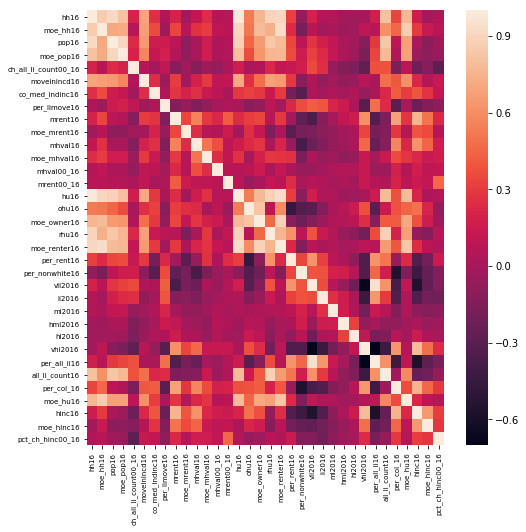

In [20]:
corr = df_16.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr)
plt.yticks(rotation=0, size=7)
plt.xticks(rotation=90, size=7)
plt.show()

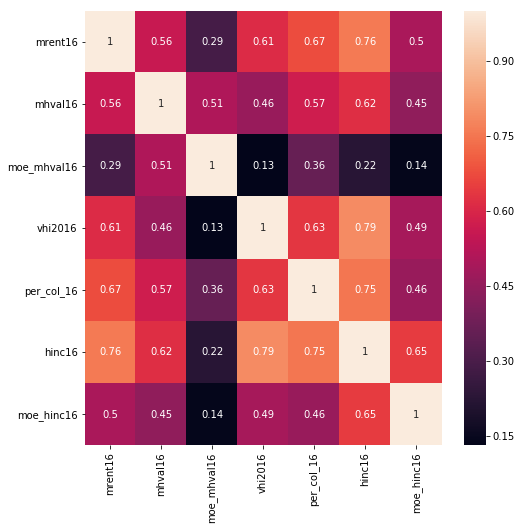

In [23]:
rel_vars = corr.mhval16 [(corr.mhval16  > 0.4)]
rel_cols = list(rel_vars.index.values)

corr2 = df_16[rel_cols].corr()
plt.figure(figsize=(8,8))
hm = sns.heatmap(corr2, annot=True, annot_kws={'size':10})
plt.yticks(rotation=0, size=10)
plt.xticks(rotation=90, size=10)
plt.show()

## After check the variable dictionary, the top three correlation variables are : per_col_16 --- "Percent college educated" /  mrent16 ---"Median house value" / vhi2016 --- "Share of very high income households". 

In [24]:
# Create a new dataframe with Geoid and geometry for variable from 2016
df_16_geo = data_census[['GEOID', 'geometry','hh16', 'moe_hh16', 'pop16', 'moe_pop16', 'ch_all_li_count00_16', 'moveinincd16', 'co_med_indinc16', 'per_limove16', 'mrent16', 'moe_mrent16', 'mhval16', 'moe_mhval16', 'mhval00_16', 'mrent00_16', 'hu16', 'ohu16', 'moe_owner16', 'rhu16', 'moe_renter16', 'per_rent16', 'per_nonwhite16', 'vli2016', 'li2016', 'mi2016', 'hmi2016', 'hi2016', 'vhi2016', 'per_all_li16', 'all_li_count16', 'per_col_16', 'moe_hu16', 'hinc16', 'moe_hinc16', 'pct_ch_hinc00_16']]

In [25]:
df_16_geo= df_16_geo.replace('nan',0)
df_16_geo= df_16_geo.replace(np.nan,0)
df_16_geo= df_16_geo.replace('NaN',0)

## Then check the clustering only for 2016 

In [26]:
# With 2016 data

print(df_16_geo.shape)

cols_X = [i for i in df_16_geo.columns if (i != 'mhval16')&(i != 'GEOID')&(i !='geometry')]
print(cols_X)

(2164, 36)
['hh16', 'moe_hh16', 'pop16', 'moe_pop16', 'ch_all_li_count00_16', 'moveinincd16', 'co_med_indinc16', 'per_limove16', 'mrent16', 'moe_mrent16', 'moe_mhval16', 'mhval00_16', 'mrent00_16', 'hu16', 'ohu16', 'moe_owner16', 'rhu16', 'moe_renter16', 'per_rent16', 'per_nonwhite16', 'vli2016', 'li2016', 'mi2016', 'hmi2016', 'hi2016', 'vhi2016', 'per_all_li16', 'all_li_count16', 'per_col_16', 'moe_hu16', 'hinc16', 'moe_hinc16', 'pct_ch_hinc00_16']


In [27]:
X = np.asarray(df_16_geo[cols_X])
print(X.shape)
y = np.asarray(df_16_geo['mhval16'])
y

(2164, 33)


array([ 557700.,  827200.,  490200., ...,       0.,  537900., 1146400.])

In [32]:
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

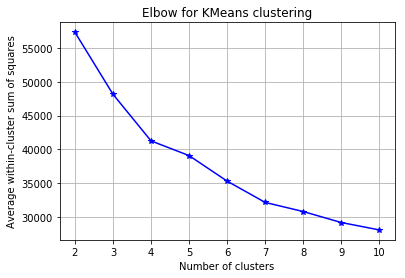

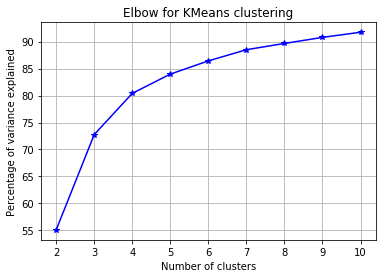

In [33]:
elbow(X, range(2,11))

In [34]:
range_n_clusters = range(2,20)

for n_clusters in range_n_clusters:
    km = KMeans(n_clusters = n_clusters)
    res=km.fit(X)
    silhouette_avg = silhouette_score(X, res.labels_)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))
    
        

For n_clusters = 2, the average silhouette_score is : 0.7029014192702603
For n_clusters = 3, the average silhouette_score is : 0.5899144138060421
For n_clusters = 4, the average silhouette_score is : 0.45975127475277344
For n_clusters = 5, the average silhouette_score is : 0.4148676211207672
For n_clusters = 6, the average silhouette_score is : 0.3274562966858249
For n_clusters = 7, the average silhouette_score is : 0.3350718803762613
For n_clusters = 8, the average silhouette_score is : 0.3085454226206166
For n_clusters = 9, the average silhouette_score is : 0.333731723101542
For n_clusters = 10, the average silhouette_score is : 0.32026525012466495
For n_clusters = 11, the average silhouette_score is : 0.3325162348161557
For n_clusters = 12, the average silhouette_score is : 0.3123117563703644
For n_clusters = 13, the average silhouette_score is : 0.3282692800503899
For n_clusters = 14, the average silhouette_score is : 0.2996461566614122
For n_clusters = 15, the average silhouette_s

In [35]:
n=4 # number of clusters
dd=X #data
tar=y # real target

km=KMeans(n_clusters=n)
res=km.fit(dd)

In [36]:
y_clusters = res.labels_
y_clusters

array([2, 2, 2, ..., 0, 0, 2], dtype=int32)

In [37]:
df_16_geo['clusters'] =y_clusters
df_16_geo['clusters'].unique()
df_16_geo.to_csv('clusters_16.csv')
df_16_geo.tail(3)

,GEOID,geometry,hh16,moe_hh16,pop16,moe_pop16,ch_all_li_count00_16,moveinincd16,co_med_indinc16,per_limove16,...,hi2016,vhi2016,per_all_li16,all_li_count16,per_col_16,moe_hu16,hinc16,moe_hinc16,pct_ch_hinc00_16,clusters
2161,36061021900,"POLYGON ((-73.9554510000636 40.81937700004859,...",2083.0,115.0,6415.0,755.0,-57.557861,506.445,75513.0,0.719861,...,0.032178,0.065179,0.836641,1742.723755,0.186234,81.0,21585.0,5374.0,-0.138131,0
2162,36061022102,POLYGON ((-73.94515500010318 40.82087599992749...,1117.0,97.0,2451.0,291.0,22.305359,245.920,75513.0,0.788569,...,0.066406,0.204434,0.593489,662.927551,0.519689,69.0,41635.0,13171.0,-0.048740,0
2163,36047152200,"POLYGON ((-73.96408699991511 40.6444069999831,...",1064.0,59.0,3496.0,370.0,30.123215,173.047,50640.0,0.607703,...,0.120580,0.548916,0.266917,284.000000,0.561866,49.0,85147.0,22920.0,0.007667,2


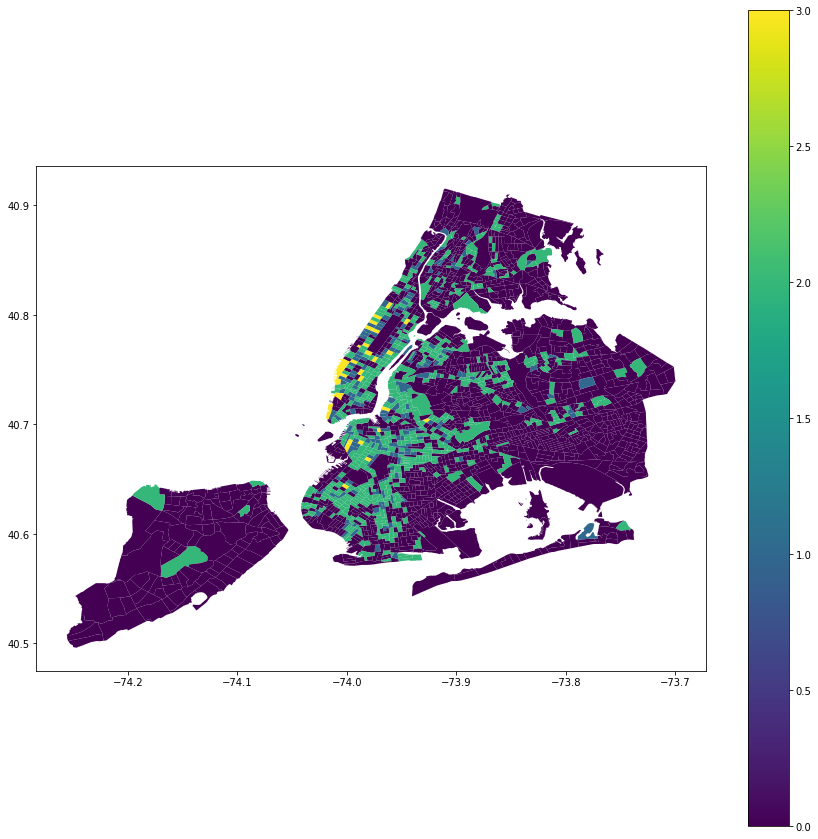

In [38]:
figure, ax = plt.subplots(figsize=(15, 15))
df_16_geo.plot(column='clusters',legend = True, ax=ax)

## Redo for 2010 and 1990 ---> check if the cluster was changed 

In [39]:
cols_00 = []
for column in data_census.columns:
    if '00' in column:
        cols_00.append(column)
cols_00 
print(len(cols_00),cols_00)

26 ['per_col00', 'per_nonwhite00', 'per_rent00', 'vli2000', 'li2000', 'mi2000', 'hmi2000', 'hi2000', 'vhi2000', 'per_all_li00', 'hh00', 'all_li_count00', 'pop00', 'ch_all_li_count90_00', 'ch_all_li_count00_16', 'mrent00', 'rou00', 'mhval00', 'ohu00', 'mhval90_00', 'mhval00_16', 'mrent90_00', 'mrent00_16', 'hinc00', 'pct_ch_hinc90_00', 'pct_ch_hinc00_16']


In [40]:
#create matrix with independent variable 

In [41]:
df_00 = data_census[['per_col00', 'per_nonwhite00', 'per_rent00', 'vli2000', 'li2000', 'mi2000', 'hmi2000', 'hi2000', 'vhi2000', 'per_all_li00', 'hh00', 'all_li_count00', 'pop00', 'ch_all_li_count90_00', 'ch_all_li_count00_16', 'mrent00', 'rou00', 'mhval00', 'ohu00', 'mhval90_00', 'mhval00_16', 'mrent90_00', 'mrent00_16', 'hinc00', 'pct_ch_hinc90_00', 'pct_ch_hinc00_16']]
df_00.head()

,per_col00,per_nonwhite00,per_rent00,vli2000,li2000,mi2000,hmi2000,hi2000,vhi2000,per_all_li00,...,rou00,mhval00,ohu00,mhval90_00,mhval00_16,mrent90_00,mrent00_16,hinc00,pct_ch_hinc90_00,pct_ch_hinc00_16
0,0.308353,0.392846,0.588881,0.165321,0.138535,0.059451,0.100951,0.138998,0.396744,0.303856,...,858.000000,230500.000000,599.000000,-0.010305,1.419523,0.371069,0.772936,77528.600000,0.024456,-0.217644
1,0.165272,0.955867,0.883148,0.487993,0.198152,0.073064,0.044690,0.072732,0.123368,0.686145,...,1111.000000,133982.312925,147.000000,-0.021966,5.173949,0.638764,2.009309,31193.126153,0.338241,1.463107
2,0.779420,0.170020,0.618152,0.119530,0.063569,0.035175,0.065627,0.095087,0.621012,0.183099,...,1024.565796,217699.995305,632.898621,-0.564601,1.251723,0.643761,1.198020,94268.847010,0.237521,0.069335
3,0.091283,0.955941,0.451968,0.248304,0.170377,0.082061,0.139400,0.113894,0.245964,0.418681,...,598.304321,192400.007635,725.471985,0.269967,1.123700,0.085799,0.998638,61377.049024,-0.045143,0.131579
4,0.124260,0.993137,0.651192,0.389734,0.147430,0.087068,0.033895,0.064730,0.277142,0.537164,...,519.000000,151700.000000,278.000000,0.348444,1.257086,-0.027027,0.805556,33757.450000,-0.019158,-0.148336


In [42]:
df_00= df_00.replace('nan',0)
df_00= df_00.replace(np.nan,0)
df_00= df_00.replace('NaN',0)
df_00.shape

(2164, 26)

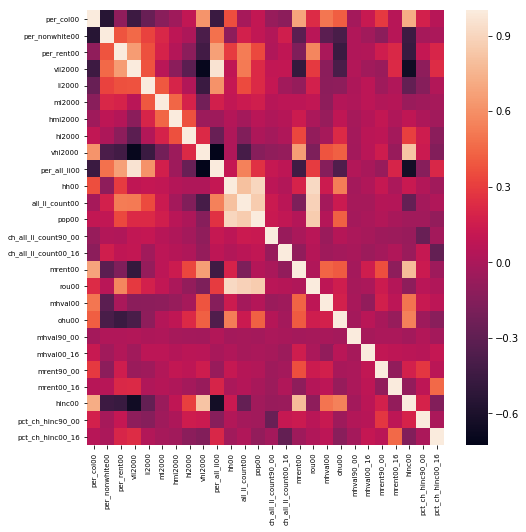

In [43]:
corr = df_00.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr)
plt.yticks(rotation=0, size=7)
plt.xticks(rotation=90, size=7)
plt.show()

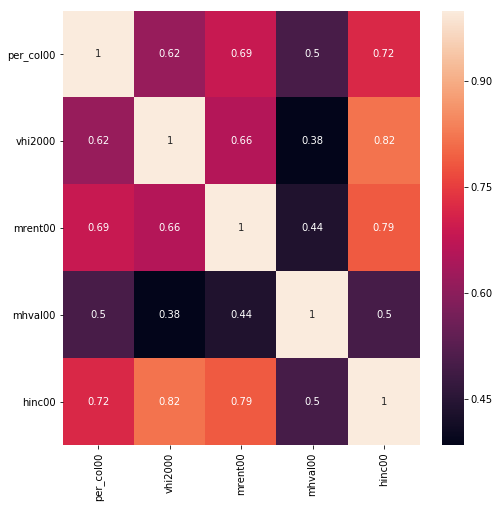

In [44]:
rel_vars = corr.mhval00 [(corr.mhval00  > 0.2)]
rel_cols = list(rel_vars.index.values)

corr2 = df_00[rel_cols].corr()
plt.figure(figsize=(8,8))
hm = sns.heatmap(corr2, annot=True, annot_kws={'size':10})
plt.yticks(rotation=0, size=10)
plt.xticks(rotation=90, size=10)
plt.show()

## Same as 2016,  in 2000, the top three correlation variables are : per_col_16 --- "Percent college educated" /  mrent16 ---"Median house value" / vhi2016 --- "Share of very high income households".  (the college one is intresting, but the income one is kinda obvious i feel) 

# perform clustering on data from 2000

In [45]:
# Create a new dataframe with Geoid and geometry for variable from 2000
df_00_geo = data_census[['GEOID', 'geometry', 'per_col00', 'per_nonwhite00', 'per_rent00', 'vli2000', 'li2000', 'mi2000', 'hmi2000', 'hi2000', 'vhi2000', 'per_all_li00', 'hh00', 'all_li_count00', 'pop00', 'ch_all_li_count90_00', 'ch_all_li_count00_16', 'mrent00', 'rou00', 'mhval00', 'ohu00', 'mhval90_00', 'mhval00_16', 'mrent90_00', 'mrent00_16', 'hinc00', 'pct_ch_hinc90_00', 'pct_ch_hinc00_16']]
df_00_geo.head()

,GEOID,geometry,per_col00,per_nonwhite00,per_rent00,vli2000,li2000,mi2000,hmi2000,hi2000,...,rou00,mhval00,ohu00,mhval90_00,mhval00_16,mrent90_00,mrent00_16,hinc00,pct_ch_hinc90_00,pct_ch_hinc00_16
0,36081113900,POLYGON ((-73.79190199967752 40.76893599959674...,0.308353,0.392846,0.588881,0.165321,0.138535,0.059451,0.100951,0.138998,...,858.000000,230500.000000,599.000000,-0.010305,1.419523,0.371069,0.772936,77528.600000,0.024456,-0.217644
1,36061025700,POLYGON ((-73.95068000038171 40.81084300040413...,0.165272,0.955867,0.883148,0.487993,0.198152,0.073064,0.044690,0.072732,...,1111.000000,133982.312925,147.000000,-0.021966,5.173949,0.638764,2.009309,31193.126153,0.338241,1.463107
2,36047000502,POLYGON ((-73.99136499969497 40.69701000031133...,0.779420,0.170020,0.618152,0.119530,0.063569,0.035175,0.065627,0.095087,...,1024.565796,217699.995305,632.898621,-0.564601,1.251723,0.643761,1.198020,94268.847010,0.237521,0.069335
3,36081015802,POLYGON ((-73.81497399975029 40.68669500037402...,0.091283,0.955941,0.451968,0.248304,0.170377,0.082061,0.139400,0.113894,...,598.304321,192400.007635,725.471985,0.269967,1.123700,0.085799,0.998638,61377.049024,-0.045143,0.131579
4,36047116000,POLYGON ((-73.88618300014529 40.66752100019399...,0.124260,0.993137,0.651192,0.389734,0.147430,0.087068,0.033895,0.064730,...,519.000000,151700.000000,278.000000,0.348444,1.257086,-0.027027,0.805556,33757.450000,-0.019158,-0.148336


In [46]:
df_00_geo= df_00_geo.replace('nan',0)
df_00_geo= df_00_geo.replace(np.nan,0)
df_00_geo= df_00_geo.replace('NaN',0)

In [47]:
# With 2000 data

print(df_00_geo.shape)

cols_X = [i for i in df_00_geo.columns if (i != 'mhval00')&(i != 'GEOID')&(i !='geometry')]
print(cols_X)

(2164, 28)
['per_col00', 'per_nonwhite00', 'per_rent00', 'vli2000', 'li2000', 'mi2000', 'hmi2000', 'hi2000', 'vhi2000', 'per_all_li00', 'hh00', 'all_li_count00', 'pop00', 'ch_all_li_count90_00', 'ch_all_li_count00_16', 'mrent00', 'rou00', 'ohu00', 'mhval90_00', 'mhval00_16', 'mrent90_00', 'mrent00_16', 'hinc00', 'pct_ch_hinc90_00', 'pct_ch_hinc00_16']


In [48]:
X_00 = np.asarray(df_00_geo[cols_X])
print(X.shape)
y_00 = np.asarray(df_00_geo['mhval00'])
y_00

(2164, 33)


array([230500.        , 133982.31292517, 217699.99530495, ...,
       625000.        , 175000.        , 361840.60721063])

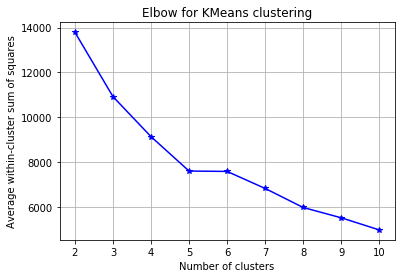

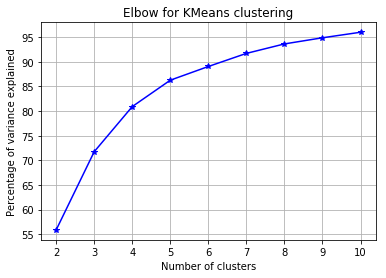

In [49]:
elbow(X_00, range(2,11))

In [50]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

range_n_clusters = range(2,20)

for n_clusters in range_n_clusters:
    km = KMeans(n_clusters = n_clusters)
    res=km.fit(X_00)
    silhouette_avg = silhouette_score(X_00, res.labels_)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))
    

For n_clusters = 2, the average silhouette_score is : 0.5518688721634138
For n_clusters = 3, the average silhouette_score is : 0.4976672614017573
For n_clusters = 4, the average silhouette_score is : 0.5008306909068146
For n_clusters = 5, the average silhouette_score is : 0.4989564273381826
For n_clusters = 6, the average silhouette_score is : 0.5014655199244433
For n_clusters = 7, the average silhouette_score is : 0.49849750386220537
For n_clusters = 8, the average silhouette_score is : 0.475139120152105
For n_clusters = 9, the average silhouette_score is : 0.4734676578037073
For n_clusters = 10, the average silhouette_score is : 0.4840090955238181
For n_clusters = 11, the average silhouette_score is : 0.4694330397744607
For n_clusters = 12, the average silhouette_score is : 0.46662586804177325
For n_clusters = 13, the average silhouette_score is : 0.4509342527456814
For n_clusters = 14, the average silhouette_score is : 0.44378128646521803
For n_clusters = 15, the average silhouette_

### Choose 4 as cluster number 

In [51]:
n=4 # number of clusters
dd=X_00 #data
tar=y_00 # real target

km=KMeans(n_clusters=n)
res=km.fit(dd)

In [52]:
y_clusters = res.labels_
y_clusters

array([1, 0, 1, ..., 0, 3, 1], dtype=int32)

In [53]:
df_00_geo['clusters'] =y_clusters
df_00_geo['clusters'].unique()
df_00_geo.to_csv('clusters_00.csv')
df_00_geo.tail(3)

,GEOID,geometry,per_col00,per_nonwhite00,per_rent00,vli2000,li2000,mi2000,hmi2000,hi2000,...,mhval00,ohu00,mhval90_00,mhval00_16,mrent90_00,mrent00_16,hinc00,pct_ch_hinc90_00,pct_ch_hinc00_16,clusters
2161,36061021900,"POLYGON ((-73.9554510000636 40.81937700004859,...",0.057858,0.976335,0.988011,0.621887,0.177527,0.049810,0.044513,0.040544,...,625000.000000,27.0,0.000000,-1.000000,0.372990,0.236534,25044.400,-0.002372,-0.138131,0
2162,36061022102,POLYGON ((-73.94515500010318 40.82087599992749...,0.282637,0.974572,0.827789,0.439632,0.187200,0.079572,0.056022,0.087187,...,175000.000000,176.0,-0.066667,2.073714,0.768997,1.054983,43768.250,0.229670,-0.048740,3
2163,36047152200,"POLYGON ((-73.96408699991511 40.6444069999831,...",0.422212,0.660112,0.521779,0.129393,0.100985,0.064595,0.053479,0.082005,...,361840.607211,527.0,0.205564,2.168246,0.398152,0.976885,84499.125,-0.140776,0.007667,1


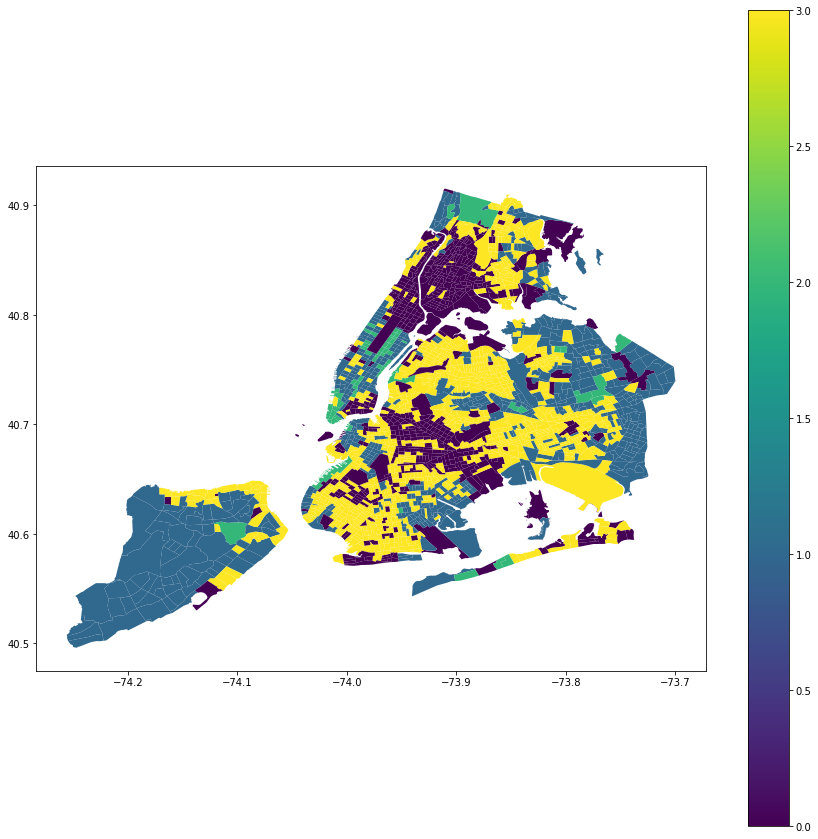

In [54]:
figure, ax = plt.subplots(figsize=(15, 15))
df_00_geo.plot(column='clusters',legend = True, ax=ax)

# Check feature importatnce of 1990 and also do clustering for data from 1990

In [55]:
cols_90 = []
for column in data_census.columns:
    if '90' in column:
        cols_90.append(column)
cols_90 
print(len(cols_90),cols_90 )

21 ['per_nonwhite90', 'per_rent90', 'vli1990', 'li1990', 'mi1990', 'hmi1990', 'hi1990', 'vhi1990', 'per_all_li90', 'all_li_count90', 'ch_all_li_count90_00', 'mrent90', 'rou90', 'mhval90', 'ohu90', 'mhval90_00', 'mrent90_00', 'pop90', 'per_col90', 'hinc90', 'pct_ch_hinc90_00']


In [56]:
df_90 = data_census[['per_nonwhite90', 'per_rent90', 'vli1990', 'li1990', 'mi1990', 'hmi1990', 'hi1990', 'vhi1990', 'per_all_li90', 'all_li_count90', 'ch_all_li_count90_00', 'mrent90', 'rou90', 'mhval90', 'ohu90', 'mhval90_00', 'mrent90_00', 'pop90', 'per_col90', 'hinc90', 'pct_ch_hinc90_00']]
df_90.head()

,per_nonwhite90,per_rent90,vli1990,li1990,mi1990,hmi1990,hi1990,vhi1990,per_all_li90,all_li_count90,...,mrent90,rou90,mhval90,ohu90,mhval90_00,mrent90_00,pop90,per_col90,hinc90,pct_ch_hinc90_00
0,0.204823,0.548056,0.151913,0.183754,0.056812,0.100683,0.121964,0.384873,0.335667,467.920013,...,636.000003,747.000000,232900.001207,616.000000,-0.010305,0.371069,3193.000000,0.250109,75677.820392,0.024456
1,1.825769,1.789007,1.076692,0.247286,0.159399,0.100824,0.194918,0.220882,1.323978,1594.069214,...,329.308509,1034.000000,136991.523996,118.000000,-0.021966,0.638764,3241.000000,0.333387,23309.056491,0.338241
2,0.071420,0.287210,0.067200,0.035058,0.031725,0.025453,0.047844,0.237797,0.102258,163.299118,...,553.000011,1030.796875,500001.015257,566.582214,-0.564601,0.643761,2668.232910,0.291718,76175.578528,0.237521
3,0.502631,0.252444,0.090191,0.115032,0.070548,0.027556,0.077901,0.178982,0.205223,239.708450,...,676.000009,526.597412,151500.002798,642.000671,0.269967,0.085799,4229.585449,0.067395,64278.752779,-0.045143
4,0.994751,0.839928,0.386384,0.162114,0.122148,0.090324,0.050832,0.188199,0.548498,329.098572,...,444.000000,467.000000,112500.000000,89.000000,0.348444,-0.027027,1905.000000,0.092979,34416.810000,-0.019158


In [57]:
df_90= df_90.replace('nan',0)
df_90= df_90.replace(np.nan,0)
df_90= df_90.replace('NaN',0)
df_90.shape

(2164, 21)

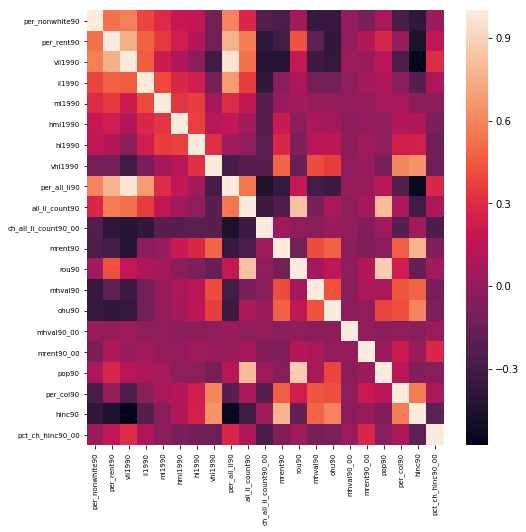

In [58]:
corr = df_90.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr)
plt.yticks(rotation=0, size=7)
plt.xticks(rotation=90, size=7)
plt.show()

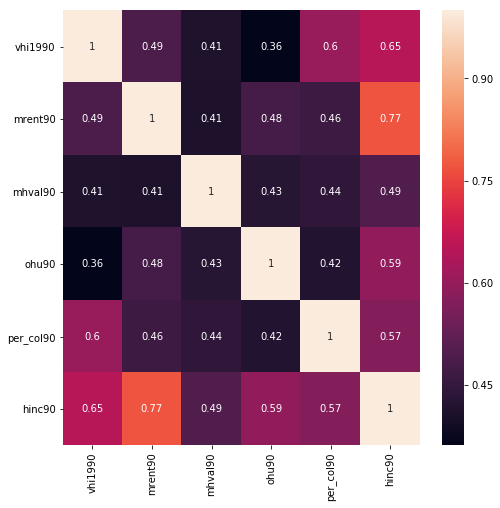

In [59]:
rel_vars = corr.mhval90 [(corr.mhval90  > 0.2)]
rel_cols = list(rel_vars.index.values)

corr2 = df_90[rel_cols].corr()
plt.figure(figsize=(8,8))
hm = sns.heatmap(corr2, annot=True, annot_kws={'size':10})
plt.yticks(rotation=0, size=10)
plt.xticks(rotation=90, size=10)
plt.show()

### Evaluate the changes of cluster between 2000

In [60]:
# Create a new dataframe with Geoid and geometry for variable from 2016
df_90_geo = data_census[['GEOID', 'geometry','per_nonwhite90', 'per_rent90', 'vli1990', 'li1990', 'mi1990', 'hmi1990', 'hi1990', 'vhi1990', 'per_all_li90', 'all_li_count90', 'ch_all_li_count90_00', 'mrent90', 'rou90', 'mhval90', 'ohu90', 'mhval90_00', 'mrent90_00', 'pop90', 'per_col90', 'hinc90', 'pct_ch_hinc90_00']]

In [61]:
df_90_geo= df_90_geo.replace('nan',0)
df_90_geo= df_90_geo.replace(np.nan,0)
df_90_geo= df_90_geo.replace('NaN',0)

In [62]:
print(df_90_geo.shape)

cols_X = [i for i in df_90_geo.columns if (i != 'mhval16')&(i != 'GEOID')&(i !='geometry')]
print(cols_X)

(2164, 23)
['per_nonwhite90', 'per_rent90', 'vli1990', 'li1990', 'mi1990', 'hmi1990', 'hi1990', 'vhi1990', 'per_all_li90', 'all_li_count90', 'ch_all_li_count90_00', 'mrent90', 'rou90', 'mhval90', 'ohu90', 'mhval90_00', 'mrent90_00', 'pop90', 'per_col90', 'hinc90', 'pct_ch_hinc90_00']


In [63]:
X_90 = np.asarray(df_90_geo[cols_X])
print(X.shape)
y_90= np.asarray(df_90_geo['mhval90'])
y_90

(2164, 33)


array([232900.00120653, 136991.5239962 , 500001.01525737, ...,
            0.        , 187500.        , 300142.25542915])

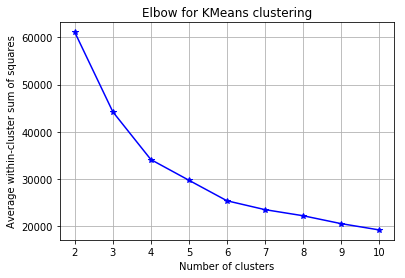

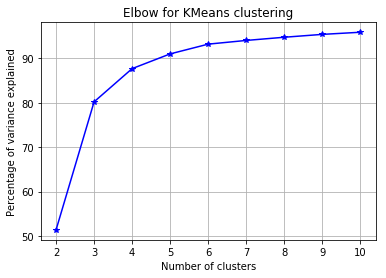

In [64]:
elbow(X_90, range(2,11))

In [65]:
range_n_clusters = range(2,20)

for n_clusters in range_n_clusters:
    km = KMeans(n_clusters = n_clusters)
    res=km.fit(X_90 )
    silhouette_avg = silhouette_score(X_90 , res.labels_)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))
    

For n_clusters = 2, the average silhouette_score is : 0.5127155146712002
For n_clusters = 3, the average silhouette_score is : 0.6104681664267608
For n_clusters = 4, the average silhouette_score is : 0.5033849339948169
For n_clusters = 5, the average silhouette_score is : 0.4732202745681003
For n_clusters = 6, the average silhouette_score is : 0.4751563393239955
For n_clusters = 7, the average silhouette_score is : 0.4348166827748366
For n_clusters = 8, the average silhouette_score is : 0.41309865828605524
For n_clusters = 9, the average silhouette_score is : 0.40736318117170905
For n_clusters = 10, the average silhouette_score is : 0.41456835146518767
For n_clusters = 11, the average silhouette_score is : 0.4119582068967275
For n_clusters = 12, the average silhouette_score is : 0.40387481305101164
For n_clusters = 13, the average silhouette_score is : 0.391822749256558
For n_clusters = 14, the average silhouette_score is : 0.37924128871100127
For n_clusters = 15, the average silhouett

In [66]:
n=4 # number of clusters
dd=X_90 #data
tar=y_90 # real target

km=KMeans(n_clusters=n)
res=km.fit(dd)

In [67]:
y_clusters = res.labels_
y_clusters

array([1, 3, 2, ..., 0, 3, 1], dtype=int32)

In [68]:
df_90_geo['clusters'] =y_clusters
df_90_geo['clusters'].unique()
df_90_geo.to_csv('clusters_90.csv')
df_90_geo.tail(3)

,GEOID,geometry,per_nonwhite90,per_rent90,vli1990,li1990,mi1990,hmi1990,hi1990,vhi1990,...,rou90,mhval90,ohu90,mhval90_00,mrent90_00,pop90,per_col90,hinc90,pct_ch_hinc90_00,clusters
2161,36061021900,"POLYGON ((-73.9554510000636 40.81937700004859,...",0.988397,0.991701,0.547147,0.183213,0.086845,0.060155,0.047117,0.075524,...,1673.0,0.000000,14.0,0.000000,0.372990,5085.0,0.055690,25103.939512,-0.002372,0
2162,36061022102,POLYGON ((-73.94515500010318 40.82087599992749...,0.939631,0.945455,0.463633,0.134022,0.108665,0.038336,0.115069,0.140275,...,780.0,187500.000000,45.0,-0.066667,0.768997,1408.0,0.161512,35593.500000,0.229670,3
2163,36047152200,"POLYGON ((-73.96408699991511 40.6444069999831,...",0.862770,0.865252,0.230287,0.074881,0.081649,0.144258,0.191281,1.277644,...,500.0,300142.255429,497.0,0.205564,0.398152,3171.0,1.036555,98343.495042,-0.140776,1


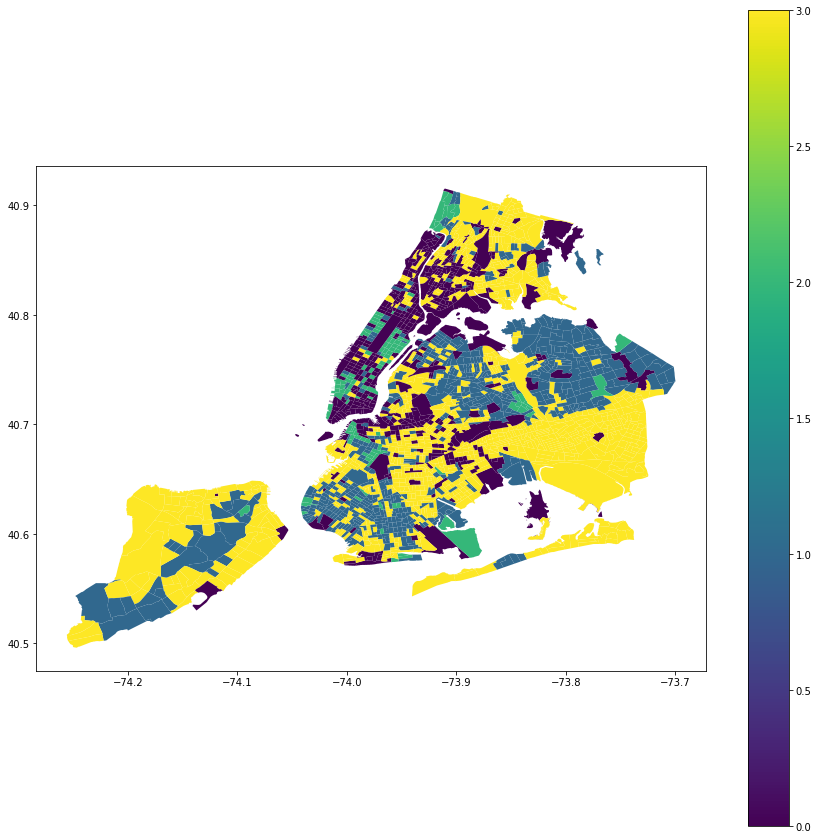

In [69]:
figure, ax = plt.subplots(figsize=(15, 15))
df_90_geo.plot(column='clusters',legend = True, ax=ax)

### Plot clusters in three diferent years, check for the cluster difference 

(-74.28342262152395, -73.67222739857235, 40.47514405028754, 40.93624094984428)

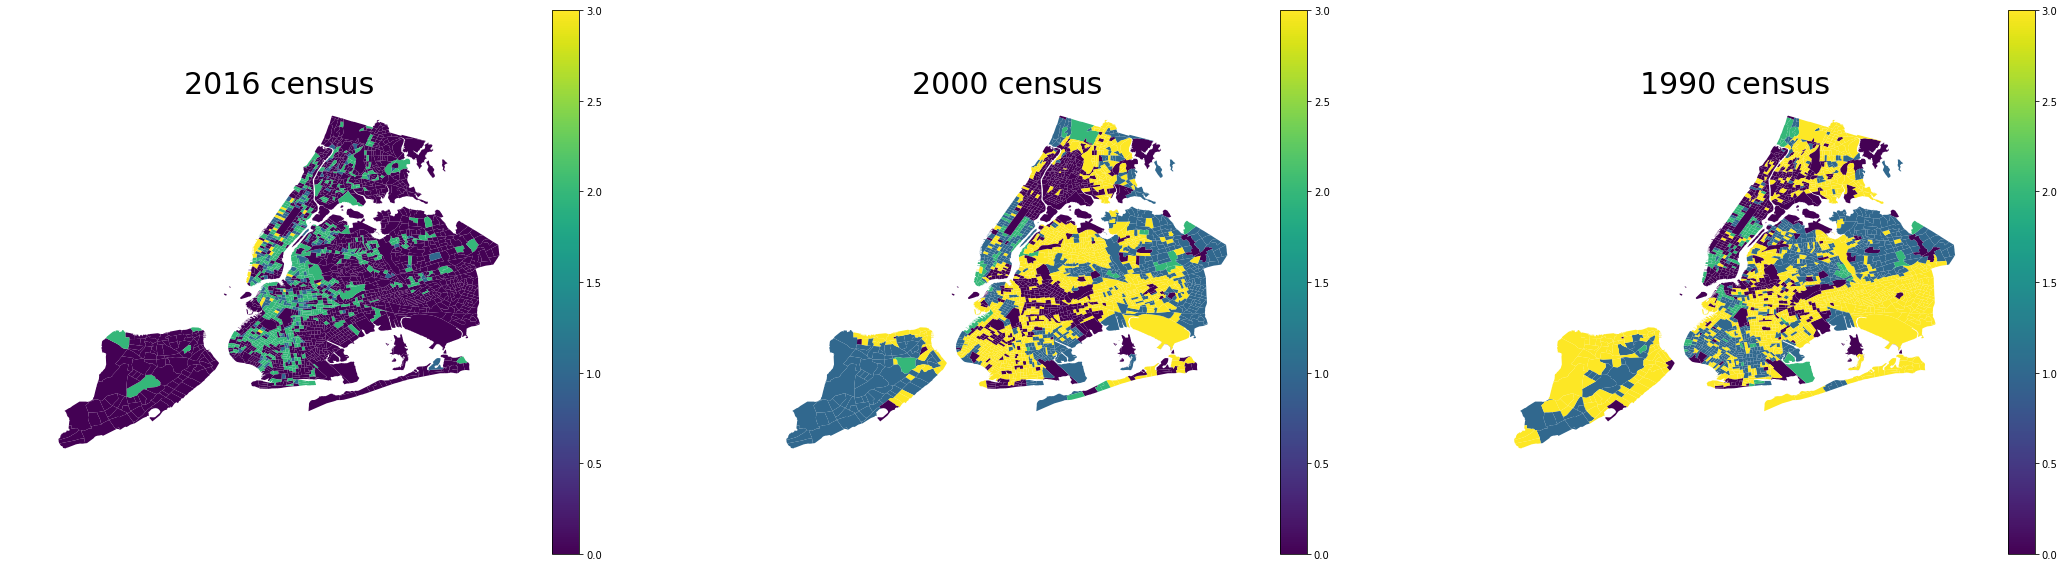

In [70]:

fig = pl.figure(figsize=(50,10))

ax1 = fig.add_subplot(141)
ax1.set_title('2016 census', fontsize=30)
#converting population to total
df_16_geo.plot(column='clusters',legend = True, ax=ax1)
ax1.axis('off')

ax2 = fig.add_subplot(142)
ax2.set_title('2000 census', fontsize=30)
df_00_geo.plot(column='clusters',legend = True, ax=ax2)
ax2.axis('off')

ax3 = fig.add_subplot(143)
ax3.set_title('1990 census', fontsize=30)
df_90_geo.plot(column='clusters',legend = True, ax=ax3)
ax3.axis('off')



## Start from here, we are trying to find out how those important features changes over time and how they contributed to different clusters in different years. 

#### Summary from the previous task, variables that have higher correlation with median property value ("mhval16/00/19") are: (list based on ranking of correlation) 
#### 2016:  "Percent college educated" / "Share of very high income households"/"Median rent value"/
#### 2000: "Percent college educated"//"Median rent value"/ Median Household income" / "Share of very high income households"
#### 1990: Median Household income"/ "Percent college educated"/"Owner-occupied housing units"/"Share of very high income households"/
#### Based on those features, we now trying to understand each clusters, and also the changes:


In [71]:
# In 2016 dataset, extract data for each cluster 

In [72]:
df_16_geo_0 = df_16_geo.loc[df_16_geo['clusters'] == 0]
df_16_geo_1 = df_16_geo.loc[df_16_geo['clusters'] == 1]
df_16_geo_2 = df_16_geo.loc[df_16_geo['clusters'] == 2]
df_16_geo_3 = df_16_geo.loc[df_16_geo['clusters'] == 3]

In [73]:
print ('mean value of median house price per each cluster:')
print (df_16_geo_0['mhval16'].mean())
print (df_16_geo_1['mhval16'].mean())
print (df_16_geo_2['mhval16'].mean())
print (df_16_geo_3['mhval16'].mean())

mean value of median house price per each cluster:
420136.1762615494
813797.7653631285
640749.2727272727
1233982.142857143


In [74]:
# check mean value 
print ('mean value of percentage of college educated per each cluster:')
print (df_16_geo_0['per_col_16'].mean())
print (df_16_geo_1['per_col_16'].mean())
print (df_16_geo_2['per_col_16'].mean())
print (df_16_geo_3['per_col_16'].mean())

mean value of percentage of college educated per each cluster:
0.2860536255212481
0.47267938265837106
0.39031642314385284
0.7029302641749382


In [75]:
print ('mean value of share of very high income households per each cluster:')
print (df_16_geo_0['vhi2016'].mean())
print (df_16_geo_1['vhi2016'].mean())
print (df_16_geo_2['vhi2016'].mean())
print (df_16_geo_3['vhi2016'].mean())

mean value of share of very high income households per each cluster:
0.33706655689298726
0.35707405326086716
0.3448041877963326
0.502770443047796


In [76]:
print ('mean value of share of median income households per each cluster:')
print (df_16_geo_0['hinc16'].mean())
print (df_16_geo_1['hinc16'].mean())
print (df_16_geo_2['hinc16'].mean())
print (df_16_geo_3['hinc16'].mean())

mean value of share of median income households per each cluster:
56895.0277185501
68664.26815642459
60879.696363636365
108565.53571428571


In [77]:
print ('mean value of median rent per each cluster:')
print (df_16_geo_0['mrent16'].mean())
print (df_16_geo_1['mrent16'].mean())
print (df_16_geo_2['mrent16'].mean())
print (df_16_geo_3['mrent16'].mean())

mean value of median rent per each cluster:
1262.4463397299219
1541.68156424581
1474.1472727272728
2093.5714285714284


Text(0.5, 1.0, 'median property price clustering map for 2016')

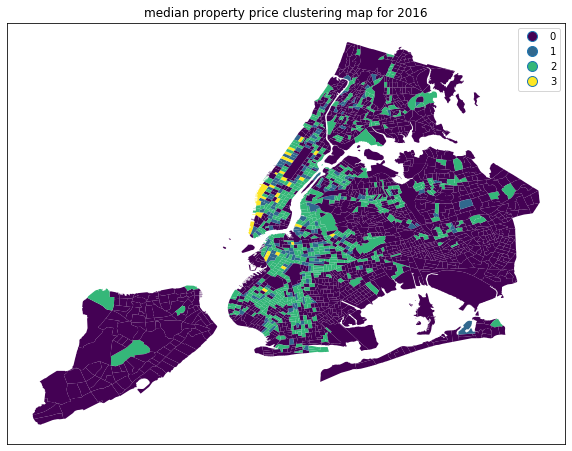

In [78]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
df_16_geo.plot(column='clusters',cmap='viridis',alpha=1,
                  linewidth=0.1,ax=ax, categorical=True,legend=True, k=10)
plt.title("median property price clustering map for 2016")

### Based on the map and mean value of those higher correlated variables, we can find out that
### cluster 1: Include Hudson Yard - Chelsea-Flatiron-Union Square/ Parts of Upper West and East Side/ parts of downtown brooklyn/ little part of Willimasburg. These areas have highest percentage of high income population, and highest percentage of college education and median household income. 

### On the contrary, cluster 0 has the lowest mean value for all the four variables. From the clustering map above, the spatial distribution of cluster 0 are mainly in inner Queens and Brooklyn. 


### Lets check 2000 data !!! 

In [79]:
df_00_geo_0 = df_00_geo.loc[df_00_geo['clusters'] == 0]
df_00_geo_1 = df_00_geo.loc[df_00_geo['clusters'] == 1]
df_00_geo_2 = df_00_geo.loc[df_00_geo['clusters'] == 2]
df_00_geo_3 = df_00_geo.loc[df_00_geo['clusters'] == 3]

In [80]:
print ('mean value of median house price per each cluster:')
print (df_00_geo_0['mhval00'].mean())
print (df_00_geo_1['mhval00'].mean())
print (df_00_geo_2['mhval00'].mean())
print (df_00_geo_3['mhval00'].mean())

mean value of median house price per each cluster:
181442.74874391285
263684.98082911666
518541.6406545601
210562.27769997157


In [81]:
# check mean value 
print ('mean value of percentage of college educated per each cluster:')
print (df_00_geo_0['per_col00'].mean())
print (df_00_geo_1['per_col00'].mean())
print (df_00_geo_2['per_col00'].mean())
print (df_00_geo_3['per_col00'].mean())

mean value of percentage of college educated per each cluster:
0.09991211035419159
0.3717192369849742
0.6856974332951582
0.21420474509129653


In [82]:
print ('mean value of median rent per each cluster:')
print (df_00_geo_0['mrent00'].mean())
print (df_00_geo_1['mrent00'].mean())
print (df_00_geo_2['mrent00'].mean())
print (df_00_geo_3['mrent00'].mean())

mean value of median rent per each cluster:
495.7267754991059
906.3100000938806
1397.0065717101697
738.5607384994885


In [83]:
print ('mean value of median income per household per each cluster:')
print (df_00_geo_0['hinc00'].mean())
print (df_00_geo_1['hinc00'].mean())
print (df_00_geo_2['hinc00'].mean())
print (df_00_geo_3['hinc00'].mean())

mean value of median income per household per each cluster:
27640.77697687001
84891.99884083413
146451.74128956822
54244.915856012245


In [84]:
print ('mean value of median rent per each cluster:')
print (df_00_geo_0['mrent00'].mean())
print (df_00_geo_1['mrent00'].mean())
print (df_00_geo_2['mrent00'].mean())
print (df_00_geo_3['mrent00'].mean())

mean value of median rent per each cluster:
495.7267754991059
906.3100000938806
1397.0065717101697
738.5607384994885


Text(0.5, 1.0, 'median property price clustering map for 2000')

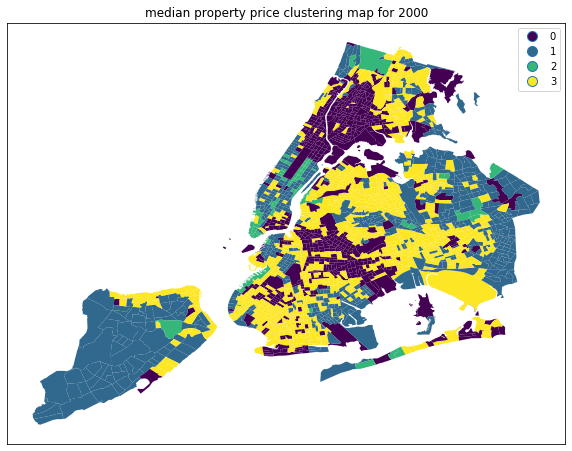

In [85]:
# check cluster map 
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
df_00_geo.plot(column='clusters',cmap='viridis',alpha=1,
                  linewidth=0.1,ax=ax, categorical=True,legend=True, k=10)
plt.title("median property price clustering map for 2000")

#### From the clustering result: 
### The areas in Cluster 0 represent the highest median property value, percentage of college education, and highest median income. The areas include: lower manhattan, east village, upper east side. and Douglas Manor/ Jamaica Estates-Holliswood( theres areas are not anymore at "highest" cluster in 2016)  
### And Cluster 3 has lowest variable values. Area includes: areas above Harlem/ inner areas of Queens and brooklyn. (Williansburge in 2000 is still in "lowest" cluster) 

In [86]:
# lets check data from 1990!! 

In [87]:
df_90_geo_0 = df_90_geo.loc[df_90_geo['clusters'] == 0]
df_90_geo_1 = df_90_geo.loc[df_90_geo['clusters'] == 1]
df_90_geo_2 = df_90_geo.loc[df_90_geo['clusters'] == 2]
df_90_geo_3 = df_90_geo.loc[df_90_geo['clusters'] == 3]

In [88]:
print ('mean value of median house price per each cluster:')
print (df_90_geo_0['mhval90'].mean())
print (df_90_geo_1['mhval90'].mean())
print (df_90_geo_2['mhval90'].mean())
print (df_90_geo_3['mhval90'].mean())

mean value of median house price per each cluster:
10310.6506633012
241939.85553957114
462719.54723601573
154477.11482040564


In [89]:
print ('mean value of median income per household per each cluster:')
print (df_90_geo_0['hinc90'].mean())
print (df_90_geo_1['hinc90'].mean())
print (df_90_geo_2['hinc90'].mean())
print (df_90_geo_3['hinc90'].mean())

mean value of median income per household per each cluster:
36646.437830059294
64598.2291641529
89627.58639196554
56513.04784481334


In [90]:
# check mean value 
print ('mean value of percentage of college educated per each cluster:')
print (df_90_geo_0['per_col90'].mean())
print (df_90_geo_1['per_col90'].mean())
print (df_90_geo_2['per_col90'].mean())
print (df_90_geo_3['per_col90'].mean())

mean value of percentage of college educated per each cluster:
0.16858069308635978
0.23616383314608883
0.5642394525731409
0.1394356209001479


In [91]:
print ('mean value of Owner-occupied housing units per each cluster:')
print (df_90_geo_0['ohu90'].mean())
print (df_90_geo_1['ohu90'].mean())
print (df_90_geo_2['ohu90'].mean())
print (df_90_geo_3['ohu90'].mean())

mean value of Owner-occupied housing units per each cluster:
149.58570446968275
482.25882837339935
764.2167039853831
358.5511023471266


In [92]:
print ('mean value of Owner-occupied housing units per each cluster:')
print (df_90_geo_0['vhi1990'].mean())
print (df_90_geo_1['vhi1990'].mean())
print (df_90_geo_2['vhi1990'].mean())
print (df_90_geo_3['vhi1990'].mean())

mean value of Owner-occupied housing units per each cluster:
0.19126921306368386
0.3706484141886724
0.5355311800976779
0.32623628990614567


Text(0.5, 1.0, 'median property price clustering map for 1990')

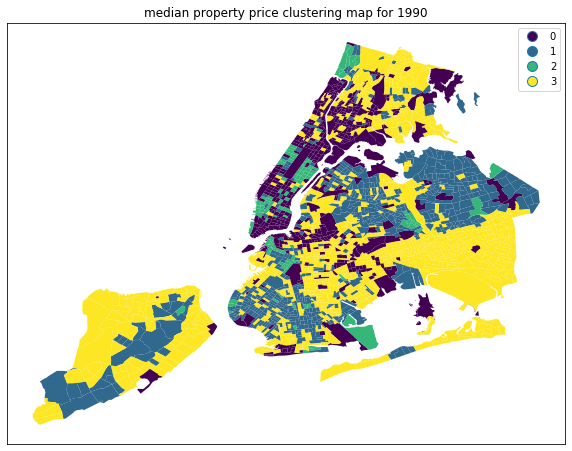

In [93]:
# check cluster map 
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
df_90_geo.plot(column='clusters',cmap='viridis',alpha=1,
                  linewidth=0.1,ax=ax, categorical=True,legend=True, k=10)
plt.title("median property price clustering map for 1990")

### In 1990, The cluster has highest value (cluster0) and cluster has lowest value (cluster 2) are both located in Manhattan. The "highest" areas are still in upper East/West side and lower manhattan area; however the other area is lowest part.

### (One of the reason might be 1990 has more missing data than other two years) 

## Because census from 1990 has too much missing data. Lets check the changes of different variable in those clusers from 2000 to 2016. We aim to find the area that changes the most.
### We will calculate the difference between 2016 and 2000 of different variable. The dataset we are using already have the calculated variable. we can directly use. 

In [94]:
data_census.columns

Index(['GEOID', 'geometry', 'hh16', 'moe_hh16', 'per_col00', 'per_nonwhite00',
       'per_rent00', 'vli2000', 'li2000', 'mi2000', 'hmi2000', 'hi2000',
       'vhi2000', 'per_all_li00', 'hh00', 'all_li_count00', 'per_nonwhite90',
       'per_rent90', 'vli1990', 'li1990', 'mi1990', 'hmi1990', 'hi1990',
       'vhi1990', 'denominator', 'per_all_li90', 'all_li_count90', 'pop00',
       'pop16', 'moe_pop16', 'ch_all_li_count90_00', 'ch_all_li_count00_16',
       'moveinincd16', 'co_med_indinc16', 'per_limove16', 'per_limove09',
       'TOD', 'empd15', 'mrent90', 'rou90', 'mrent00', 'rou00', 'mrent16',
       'moe_mrent16', 'mhval90', 'ohu90', 'mhval00', 'ohu00', 'mhval16',
       'moe_mhval16', 'mhval90_00', 'mhval00_16', 'mrent90_00', 'mrent00_16',
       'hu16', 'per_units_pre50', 'ohu16', 'moe_owner16', 'rhu16',
       'moe_renter16', 'per_rent16', 'per_nonwhite16', 'vli2016', 'li2016',
       'mi2016', 'hmi2016', 'hi2016', 'vhi2016', 'per_all_li16',
       'all_li_count16', 'ag25up', '

In [95]:
df_16_geo.columns

Index(['GEOID', 'geometry', 'hh16', 'moe_hh16', 'pop16', 'moe_pop16',
       'ch_all_li_count00_16', 'moveinincd16', 'co_med_indinc16',
       'per_limove16', 'mrent16', 'moe_mrent16', 'mhval16', 'moe_mhval16',
       'mhval00_16', 'mrent00_16', 'hu16', 'ohu16', 'moe_owner16', 'rhu16',
       'moe_renter16', 'per_rent16', 'per_nonwhite16', 'vli2016', 'li2016',
       'mi2016', 'hmi2016', 'hi2016', 'vhi2016', 'per_all_li16',
       'all_li_count16', 'per_col_16', 'moe_hu16', 'hinc16', 'moe_hinc16',
       'pct_ch_hinc00_16', 'clusters'],
      dtype='object')

In [104]:
# Create variable of changes from 2000 to 2016:
data_census['ch_hh']=data_census['hh16']-data_census['hh00'] #change of number of household 
data_census['ch_pop'] = data_census['pop16']-data_census['pop00'] #change of number of household
data_census['ch_nonwhite'] = (data_census['per_nonwhite16']* data_census['pop16'])- \
                            (data_census['per_nonwhite00']* data_census['pop00']) # change on non-white population
data_census['ch_ohu'] =  data_census['ohu16']-data_census['ohu00'] # Change of Owner-occupied housing units
data_census['ch_rhu'] = data_census['rhu16']-data_census['rou00'] #Changes of Renter-occupied housing units
data_census['ch_col'] = (data_census['per_col_16']* data_census['pop16'])- \
                            (data_census['per_col00']* data_census['pop00'])# Change of college population
data_census['ch_mhval'] = data_census['mhval16']-data_census['mhval00'] # change of median house price
data_census['ch_mrent'] = data_census['mrent16']-data_census['mrent00'] # change of median rent 

In [105]:
cols_ch = []
for column in data_census.columns:
    if 'ch_' in column:
        cols_ch.append(column)
cols_ch 
print(len(cols_ch),cols_ch )

12 ['ch_all_li_count90_00', 'ch_all_li_count00_16', 'pct_ch_hinc90_00', 'pct_ch_hinc00_16', 'ch_hh', 'ch_pop', 'ch_nonwhite', 'ch_ohu', 'ch_rhu', 'ch_col', 'ch_mhval', 'ch_mrent']


In [111]:
df_ch = data_census[['GEOID', 'geometry','ch_all_li_count90_00', 'ch_all_li_count00_16', 'pct_ch_hinc90_00', 'pct_ch_hinc00_16', 'ch_hh', 'ch_pop', 'ch_nonwhite', 'ch_ohu', 'ch_rhu', 'ch_col', 'ch_mhval', 'ch_mrent']]
df_ch.head()

,GEOID,geometry,ch_all_li_count90_00,ch_all_li_count00_16,pct_ch_hinc90_00,pct_ch_hinc00_16,ch_hh,ch_pop,ch_nonwhite,ch_ohu,ch_rhu,ch_col,ch_mhval,ch_mrent
0,36081113900,POLYGON ((-73.79190199967752 40.76893599959674...,-25.201660,133.823456,0.024456,-0.217644,-88.000000,-117.000000,690.000065,10.000000,-98.000000,42.726673,327200.000000,674.000000
1,36061025700,POLYGON ((-73.95068000038171 40.81084300040413...,-730.898315,-126.051941,0.338241,1.463107,545.000000,1588.000000,397.000122,447.000000,98.000000,2412.427383,693217.687075,1084.341134
2,36047000502,POLYGON ((-73.99136499969497 40.69701000031133...,140.181107,7.001373,0.237521,0.069335,-129.464478,-80.943115,155.126230,-120.898621,-8.565796,163.806271,272500.004695,1088.999980
3,36081015802,POLYGON ((-73.81497399975029 40.68669500037402...,314.531799,-100.156677,-0.045143,0.131579,-88.776367,-46.000000,-105.758757,-10.471985,-78.304321,470.039613,216199.992365,732.999986
4,36047116000,POLYGON ((-73.88618300014529 40.66752100019399...,99.021484,124.415955,-0.019158,-0.148336,99.000000,-446.000000,-429.000059,-13.000000,112.000000,-13.908952,190700.000000,348.000000


In [112]:
## Use another clustering method Gaussian Mixture Models (EM)

In [118]:
df_ch= df_ch.replace('nan',0)
df_ch= df_ch.replace(np.nan,0)
df_ch= df_ch.replace('NaN',0)
df_ch.shape

(2164, 14)

Text(0.5, 1.0, 'median property price changes for 2000 -2016 changes')

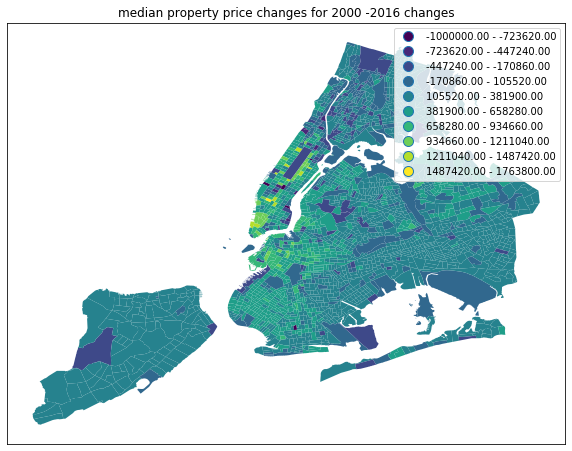

In [137]:
# check cluster map for median price change 
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
df_ch.plot(column='ch_mhval',cmap='viridis',alpha=1,
                  linewidth=0.1,ax=ax, scheme="Equal_interval",legend=True, k=10)
plt.title("median property price changes for 2000 -2016 changes")

Text(0.5, 1.0, 'college population changes from 2000 -2016 changes')

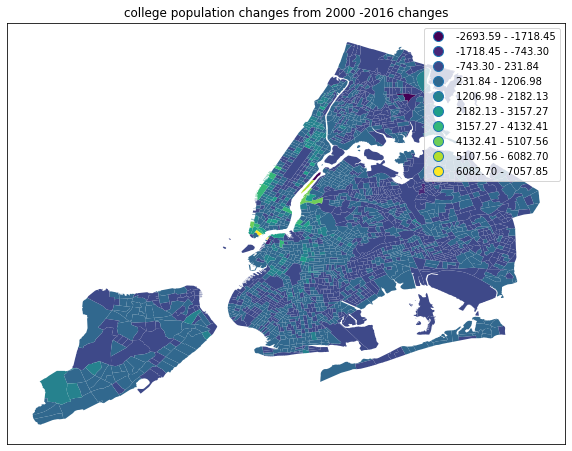

In [145]:
#  map for college population change 
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
df_ch.plot(column='ch_col',cmap='viridis',alpha=1,
                  linewidth=0.1,ax=ax, scheme="Equal_interval",legend=True, k=10)
plt.title("college population changes from 2000 -2016 changes")

Text(0.5, 1.0, 'non-white population changes from 2000 -2016 changes')

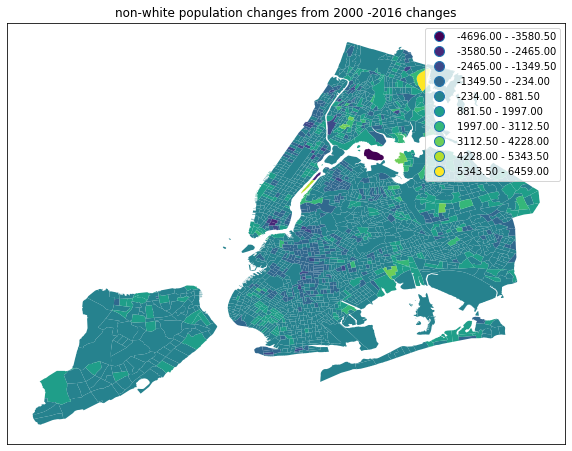

In [144]:
# map for non_white population change
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
df_ch.plot(column='ch_nonwhite',cmap='viridis',alpha=1,
                  linewidth=0.1,ax=ax, scheme="Equal_interval",legend=True, k=10)
plt.title("non-white population changes from 2000 -2016 changes")

Text(0.5, 1.0, 'population changes from 2000 -2016 changes')

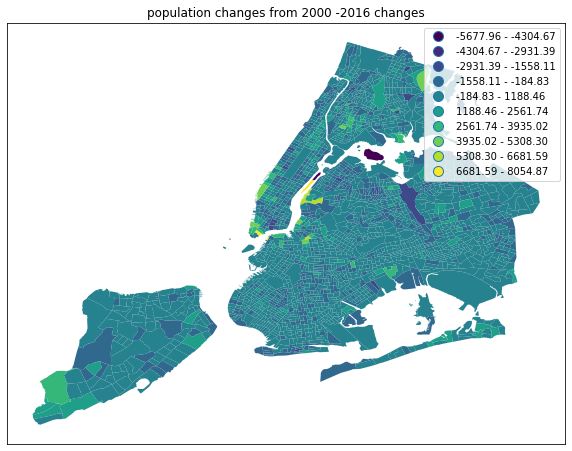

In [143]:
#  map for  population change
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
df_ch.plot(column='ch_pop',cmap='viridis',alpha=1,
                  linewidth=0.1,ax=ax, scheme="Equal_interval",legend=True, k=10)
plt.title("population changes from 2000 -2016 changes")

## Use all variable to perform clustering (might think another or better way tmr) 

In [119]:
cols_X = [i for i in df_ch.columns if (i != 'ch_mhval')&(i != 'GEOID')&(i !='geometry')]
print(cols_X)

['ch_all_li_count90_00', 'ch_all_li_count00_16', 'pct_ch_hinc90_00', 'pct_ch_hinc00_16', 'ch_hh', 'ch_pop', 'ch_nonwhite', 'ch_ohu', 'ch_rhu', 'ch_col', 'ch_mrent']


In [120]:
X_ch = np.asarray(df_ch[cols_X])
print(X.shape)
y_ch = np.asarray(df_ch['ch_mhval'])
y_ch

(2164, 33)


array([ 327200.        ,  693217.68707483,  272500.00469505, ...,
       -625000.        ,  362900.        ,  784559.39278937])

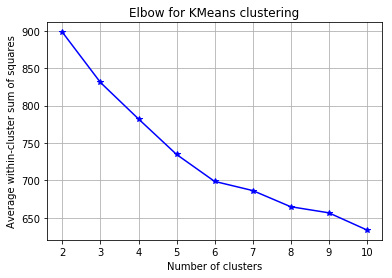

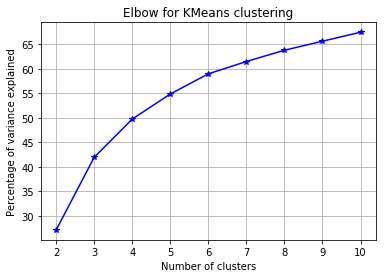

In [124]:
elbow(X_ch, range(2,11))

In [125]:
range_n_clusters = range(2,20)

for n_clusters in range_n_clusters:
    km = KMeans(n_clusters = n_clusters)
    res=km.fit(X_ch)
    silhouette_avg = silhouette_score(X_ch, res.labels_)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))
    
        

For n_clusters = 2, the average silhouette_score is : 0.3994190209626735
For n_clusters = 3, the average silhouette_score is : 0.2700123153746197
For n_clusters = 4, the average silhouette_score is : 0.2829920171319272
For n_clusters = 5, the average silhouette_score is : 0.2114432391098041
For n_clusters = 6, the average silhouette_score is : 0.22202456900833503
For n_clusters = 7, the average silhouette_score is : 0.22050457191472292
For n_clusters = 8, the average silhouette_score is : 0.1912177254557021
For n_clusters = 9, the average silhouette_score is : 0.19221763990335464
For n_clusters = 10, the average silhouette_score is : 0.17489717399506094
For n_clusters = 11, the average silhouette_score is : 0.187970888282473
For n_clusters = 12, the average silhouette_score is : 0.18831731024557016
For n_clusters = 13, the average silhouette_score is : 0.19244596184759563
For n_clusters = 14, the average silhouette_score is : 0.17846091592890062
For n_clusters = 15, the average silhoue

In [126]:
n=4 # number of clusters
dd=X_ch #data
tar=y_ch # real target

km=KMeans(n_clusters=n)
res=km.fit(dd)

In [127]:
y_clusters = res.labels_
y_clusters

array([3, 0, 3, ..., 3, 3, 3], dtype=int32)

In [128]:
df_ch['clusters'] =y_clusters
df_ch['clusters'].unique()
df_ch.to_csv('clusters_ch.csv')
df_ch.tail(3)

,GEOID,geometry,ch_all_li_count90_00,ch_all_li_count00_16,pct_ch_hinc90_00,pct_ch_hinc00_16,ch_hh,ch_pop,ch_nonwhite,ch_ohu,ch_rhu,ch_col,ch_mhval,ch_mrent,clusters
2161,36061021900,"POLYGON ((-73.9554510000636 40.81937700004859,...",514.117920,-57.557861,-0.002372,-0.138131,-169.0,-8.0,-153.999831,31.0,-200.0,823.068672,-625000.000000,101.000000,3
2162,36061022102,POLYGON ((-73.94515500010318 40.82087599992749...,194.173767,22.305359,0.229670,-0.048740,95.0,288.0,-219.000053,94.0,1.0,662.414649,362900.000000,614.000000,3
2163,36047152200,"POLYGON ((-73.96408699991511 40.6444069999831,...",-76.315445,30.123215,-0.140776,0.007667,-38.0,89.0,-202.000138,107.0,-145.0,525.806790,784559.392789,757.043478,3


Text(0.5, 1.0, 'median property price clustering map for 2000 -2016 changes')

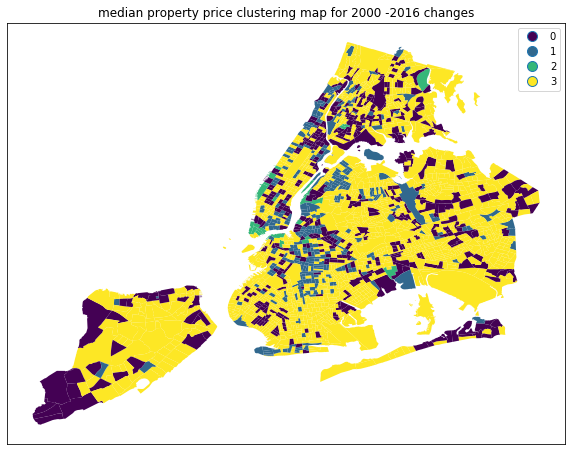

In [129]:
# check cluster map 
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
df_ch.plot(column='clusters',cmap='viridis',alpha=1,
                  linewidth=0.1,ax=ax, categorical=True,legend=True, k=10)
plt.title("median property price clustering map for 2000 -2016 changes")

In [ ]:
## Little explore on random forest prediction on 2016 data 

In [ ]:
X = df_16_new[rel_cols[:-1]].iloc[:,0:].values
y = df_16_new.iloc[:, -1].values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 0)

In [ ]:
# Fit Random Forest on Training Set
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=300, random_state=0)
regressor.fit(X_train, y_train)

# Score model
regressor.score(X_train, y_train)

In [ ]:
# Predict new result
y_pred = regressor.predict(X_test)
# Plot y_test vs y_pred
plt.figure(figsize=(12,8))
plt.plot(y_test, color='red')
plt.plot(y_pred, color='blue')
plt.show()